In [100]:
#必要なパッケージのインポート

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import reservoirpy as rpy

from scipy.integrate import solve_ivp
import pandas as pd
from reservoirpy.observables import nrmse, rsquare

from reservoirpy.datasets import to_forecasting


rpy.verbosity(0)

from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.datasets import mackey_glass

# just a little tweak to center the plots, nothing to worry about
from IPython.core.display import HTML
HTML("""
<style>
.img-center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    }
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    }
</style>
""")

rpy.set_seed(42)

%time

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 2.86 µs


In [101]:
import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd

# レスラー方程式に外力を加える
def rossler_with_forcing(t, state, a, b, c, A):
    x, y, z = state  # stateからx、y、zの値をアンパック
    forcing = A * np.sin(t)  # 外力項
    dxdt = -y - z + forcing  # xの方程式に外力を加える
    dydt = x + a * y
    dzdt = b + z * (x - c)
    return [dxdt, dydt, dzdt]

# パラメータ
a = 0.2
b = 0.2
c = 5.7
A = 1.0  # 外力の振幅を設定
initial_state = [0.0, 0.0, 0.0]
t_span = (0, 2510)

# solve_ivpでの解
sol = solve_ivp(
    rossler_with_forcing, t_span, initial_state,
    args=(a, b, c, A),
    t_eval=np.linspace(t_span[0], t_span[1], 25100),
    max_step=0.01
)

t = sol.t
x = sol.y[0]
y = sol.y[1]
z = sol.y[2]
forcing = A * np.sin(t)  # 外力のデータ

# CSVファイルにデータを保存（外力の情報も含む）
data = pd.DataFrame({
    'Time': t,
    'X': x,
    'Y': y,
    'Z': z,
    'Forcing': forcing
})
data.to_csv('rossler_with_forcing.csv', index=False)

# CSVファイルを読み込む（外力の情報も含む）
data_loaded = pd.read_csv('rossler_with_forcing.csv')

# pandas DataFrameでXにx, y, forcingを格納
X = pd.DataFrame({'x': x, 'y': y, 'Forcing': forcing}).values
print(X.shape)  # (3, 25100) と出力されるはず


(25100, 3)


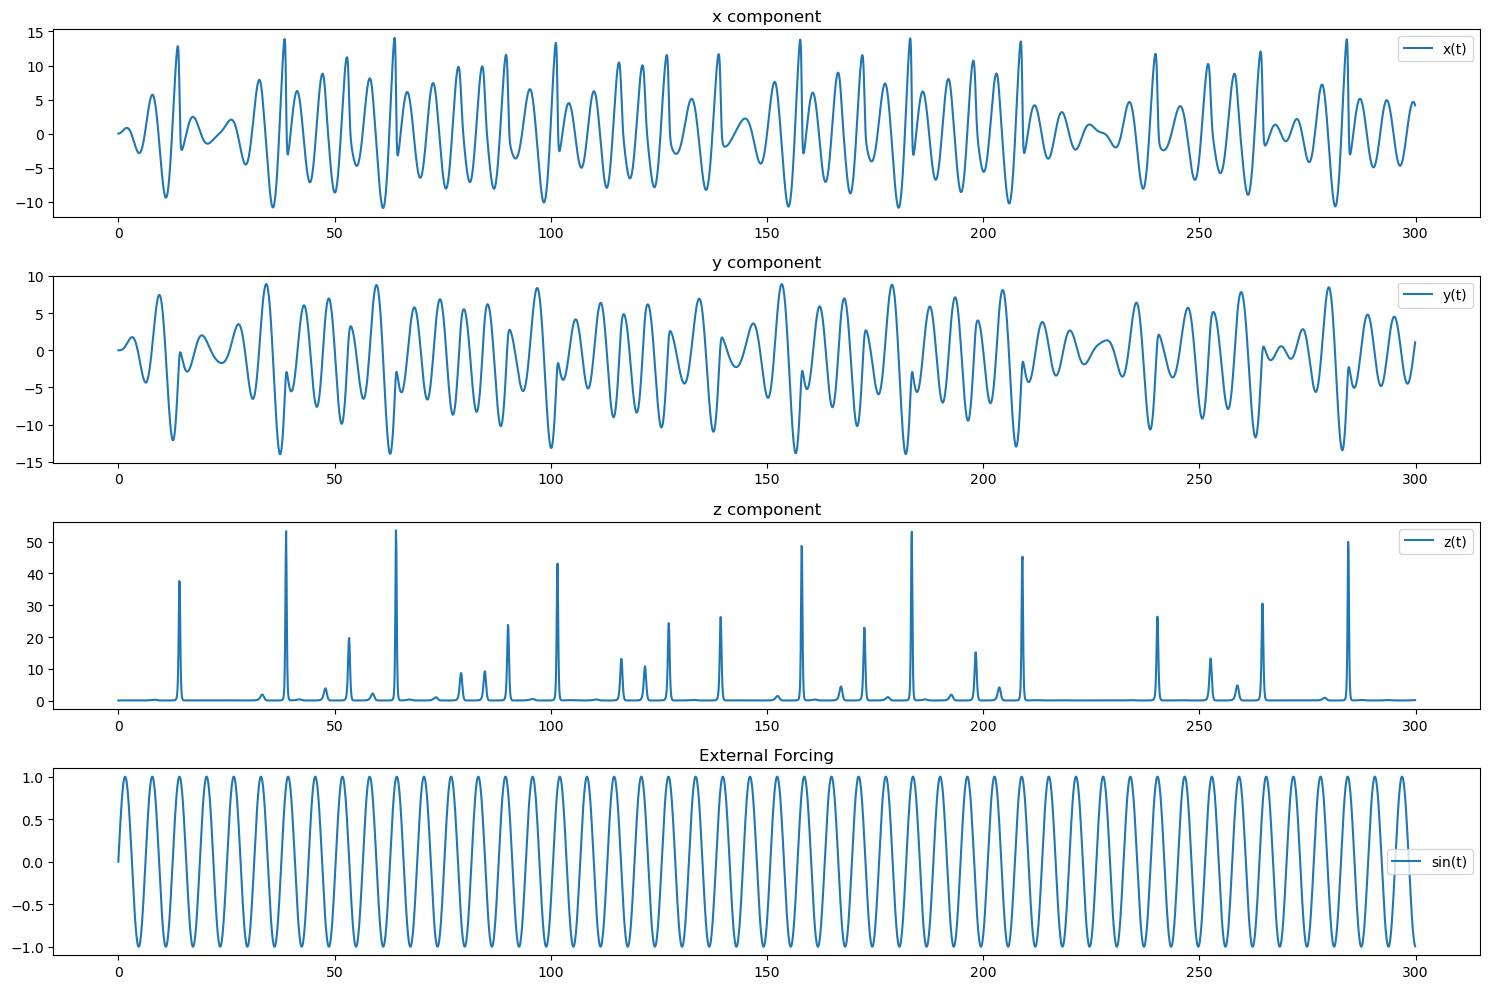

In [102]:
import matplotlib.pyplot as plt

# 最初の1000サンプルを取得
sample_end = 3000
t_sampled = t[:sample_end]
x_sampled = x[:sample_end]
y_sampled = y[:sample_end]
z_sampled = z[:sample_end]
forcing_sampled = forcing[:sample_end]

# プロット
plt.figure(figsize=(15, 10))

# xのプロット
plt.subplot(4, 1, 1)
plt.plot(t_sampled, x_sampled, label='x(t)')
plt.title('x component')
plt.legend()

# yのプロット
plt.subplot(4, 1, 2)
plt.plot(t_sampled, y_sampled, label='y(t)')
plt.title('y component')
plt.legend()

# zのプロット
plt.subplot(4, 1, 3)
plt.plot(t_sampled, z_sampled, label='z(t)')
plt.title('z component')
plt.legend()

# 外力sin(t)のプロット
plt.subplot(4, 1, 4)
plt.plot(t_sampled, forcing_sampled, label='sin(t)')
plt.title('External Forcing')
plt.legend()

plt.tight_layout()  # グラフ間のスペーシングを自動調整
plt.show()


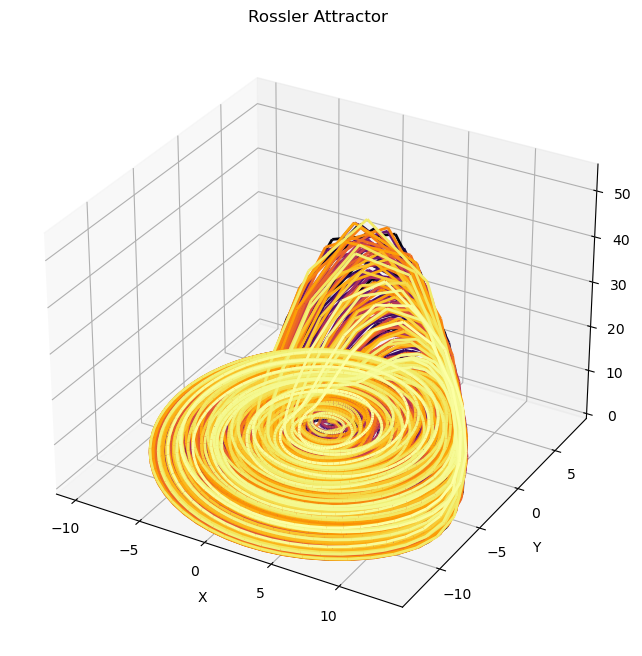

In [103]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import numpy as np

def plot_rossler_3d_colored_efficient(data):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # 時間に応じた色の変化を生成
    num_points = len(data)
    points = np.array([data['X'], data['Y'], data['Z']]).T.reshape(-1, 1, 3)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(data['Time'].min(), data['Time'].max())
    lc = Line3DCollection(segments, cmap='inferno', norm=norm)
    lc.set_array(data['Time'])
    lc.set_linewidth(2)
    ax.add_collection(lc)

    ax.set_xlim(data['X'].min(), data['X'].max())
    ax.set_ylim(data['Y'].min(), data['Y'].max())
    ax.set_zlim(data['Z'].min(), data['Z'].max())
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title('Rossler Attractor')
    plt.show()

# ここで `data_loaded` をレスラー方程式の解が含まれたデータフレームと仮定しています。
plot_rossler_3d_colored_efficient(data_loaded)


グラフの描画はうまくいっているようだ．

次に，hyperparametersの最適化を行う．


In [104]:
# Objective functions accepted by ReservoirPy must respect some conventions:
#  - dataset and config arguments are mandatory, like the empty '*' expression.
#  - all parameters that will be used during the search must be placed after the *.
#  - the function must return a dict with at least a 'loss' key containing the result
# of the loss function. You can add any additional metrics or information with other 
# keys in the dict. See hyperopt documentation for more informations.
def objective(dataset, config, *, iss, N, sr, lr, ridge, seed):
    
    # This step may vary depending on what you put inside 'dataset'
    train_data, validation_data = dataset
    X_train, y_train = train_data
    X_val, y_val = validation_data
    
    # You can access anything you put in the config 
    # file from the 'config' parameter.
    instances = config["instances_per_trial"]
    
    # The seed should be changed across the instances, 
    # to be sure there is no bias in the results 
    # due to initialization.
    variable_seed = seed 
    
    losses = []; r2s = [];
    for n in range(instances):
        # Build your model given the input parameters
        reservoir = Reservoir(N, 
                              sr=sr, 
                              lr=lr, 
                              input_scaling=iss, 
                              seed=variable_seed)
        
        readout = Ridge(ridge=ridge)

        model = reservoir >> readout


        # Train your model and test your model.
        predictions = model.fit(X_train, y_train) \
                           .run(X_test)
        
        loss = nrmse(y_test, predictions, norm_value=np.ptp(X_train))
        r2 = rsquare(y_test, predictions)
        
        # Change the seed between instances
        variable_seed += 1
        
        losses.append(loss)
        r2s.append(r2)

    # Return a dictionnary of metrics. The 'loss' key is mandatory when
    # using hyperopt.
    return {'loss': np.mean(losses),
            'r2': np.mean(r2s)}

In [105]:
hyperopt_config = {
    "exp": f"hyperopt-rossler1.1", # the experimentation name
    "hp_max_evals": 200,             # the number of differents sets of parameters hyperopt has to try
    "hp_method": "random",           # the method used by hyperopt to chose those sets (see below)
    "seed": 42,                      # the random state seed, to ensure reproducibility
    "instances_per_trial": 3,        # how many random ESN will be tried with each sets of parameters
    "hp_space": {                    # what are the ranges of parameters explored
        "N": ["choice", 1000],             # the number of neurons is fixed to 500
        "sr": ["loguniform", 1e-2, 10],   # the spectral radius is log-uniformly distributed between 1e-2 and 10
        "lr": ["loguniform", 1e-3, 1],  # idem with the leaking rate, from 1e-3 to 1
        "iss": ["uniform", 0, 1],           # the input scaling uniformly distributed between 0 and 1
        "ridge": ["loguniform", 1e-9, 1e-2],        # and so is the regularization parameter.
        "seed": ["choice", 1234]          # an other random seed for the ESN initialization
    }
}


import json

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)

In [106]:
from reservoirpy.datasets import to_forecasting

train_len = 3000
test_len = 4000

x, y = to_forecasting(X, forecast=1)
X_train, y_train = x[:train_len], y[:train_len]
X_test, y_test = x[train_len:train_len+test_len], y[train_len:train_len+test_len]

dataset = ((X_train, y_train), (X_test, y_test))

In [107]:
from reservoirpy.hyper import research

best = research(objective, dataset, "hyperopt-rossler1.1.config.json", "./hyperopt-rossler1.1")

 10%|█         | 21/200 [01:33<13:17,  4.46s/trial, best loss: 0.0008397312450397716]


KeyboardInterrupt: 

In [117]:
best

({'N': 0,
  'iss': 0.14258024657972923,
  'lr': 0.5516837456874331,
  'ridge': 3.7433235003717447e-07,
  'seed': 0,
  'sr': 0.1931498404234262},
 <hyperopt.base.Trials at 0x16b412370>)

In [118]:
N = 500
iss = best[0]['iss']
lr = best[0]['lr']
ridge = best[0]['ridge']
seed = 1234
sr = best[0]['sr']

In [138]:
# データセットからトレーニングとバリデーションデータを取得
train_data, validation_data = dataset
X_train, y_train = train_data
X_val, y_val = validation_data

# モデルの構築
reservoir = Reservoir(N, 
                      sr=sr, 
                      lr=lr, 
                      input_scaling=iss, 
                      seed=seed)
readout = Ridge(ridge=ridge)
model = reservoir >> readout

# モデルの訓練と予測
predictions = model.fit(X_train, y_train).run(X_test)

# 評価（lossとr2の計算方法は既存のものを使用しています）
loss = nrmse(y_test, predictions, norm_value=np.ptp(X_train))
r2 = rsquare(y_test, predictions)

print("Loss:", loss)
print("R^2:", r2)

Loss: 0.0007668443960525167
R^2: 0.9999735343178006


In [141]:
predictions-y_test

array([[ 0.01331784, -0.00404397, -0.00019324],
       [ 0.01721888, -0.00305761, -0.00018955],
       [ 0.0186318 , -0.00069951, -0.0001568 ],
       ...,
       [ 0.01476371,  0.01256949,  0.00018307],
       [ 0.01216791,  0.01223334,  0.00015818],
       [ 0.00770669,  0.01121214,  0.00012209]])

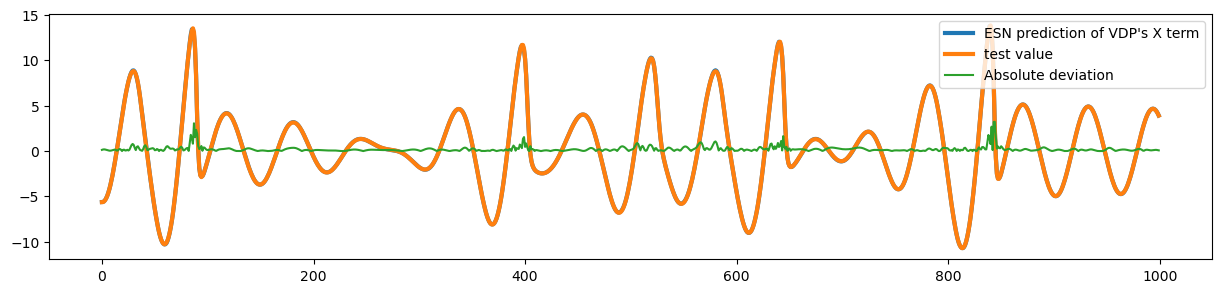

In [142]:
sample = 1000

fig = plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(np.arange(sample), predictions[:, :1][:sample], lw=3, label="ESN prediction of VDP's X term")
plt.plot(np.arange(sample), y_test[:, :1][:sample], lw=3, label="test value")
plt.plot(10*np.abs(y_test[:, :1][:sample] - predictions[:, :1][:sample]), label="Absolute deviation")


plt.legend()
plt.show()

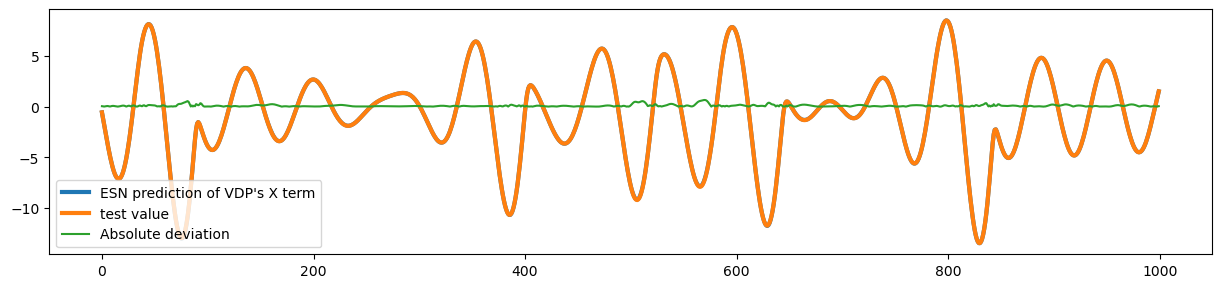

In [143]:
sample = 1000

fig = plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(np.arange(sample), predictions[:, 1:2][:sample], lw=3, label="ESN prediction of VDP's X term")
plt.plot(np.arange(sample), y_test[:, 1:2][:sample], lw=3, label="test value")
plt.plot(10*np.abs(y_test[:, 1:2][:sample] - predictions[:, 1:2][:sample]), label="Absolute deviation")


plt.legend()
plt.show()

In [144]:
train_len = 2000 
forecast=1 
seed_timesteps = 100 
nb_generations = 400

n, m = X.shape

train_len = train_len

x, y = to_forecasting(X, forecast=forecast)
X_train, y_train = x[:train_len], y[:train_len]
X_test, y_test = x[train_len:], y[train_len:]

dataset = ((X_train, y_train), (X_test, y_test))

# データセットからトレーニングとバリデーションデータを取得
train_data, validation_data = dataset
X_train, y_train = train_data
X_val, y_val = validation_data

# モデルの構築
reservoir = Reservoir(N, 
                    sr=sr, 
                    lr=lr, 
                    input_scaling=iss, 
                    seed=seed)
readout = Ridge(ridge=ridge)
model = reservoir >> readout

# モデルの訓練と予測
predictions = model.fit(X_train, y_train).run(X_val)

In [145]:
seed_timesteps = seed_timesteps
nb_generations = 1500
#実際は150ステップに対応

warming_inputs = X_test[:seed_timesteps]

warming_out = model.run(warming_inputs, reset=True)  # warmup
print(f"{warming_out[-1]}:warming_out[-1]")
print(f"{X_test[seed_timesteps]}:X_test[seed_timesteps]")
#warming_outはX_test[seed_timesteps]を近似する．

[-1.4158084  -3.68684143  0.46008017]:warming_out[-1]
[-1.40176192 -3.68799994  0.46030695]:X_test[seed_timesteps]


In [146]:
X_gen = np.zeros((nb_generations, m))
y = warming_out[-1] 
print(y.shape) 
y = y.reshape(1, -1) 
print(y.shape) #配列の形式は(n, m)の二次元配列にする必要があるので調整した

(3,)
(1, 3)


In [147]:
for t in range(nb_generations):  
    y[:, 2:3] = X_test[seed_timesteps+t, 2:3] #外力にあたる[:, 2:3]に実測値を代入する．
    y = model(y) #ESNで1回=0.1ステップ先を予測する．
    X_gen[t, :] = y #配列に記録していく
            
X_t = X_test[seed_timesteps: nb_generations+seed_timesteps]

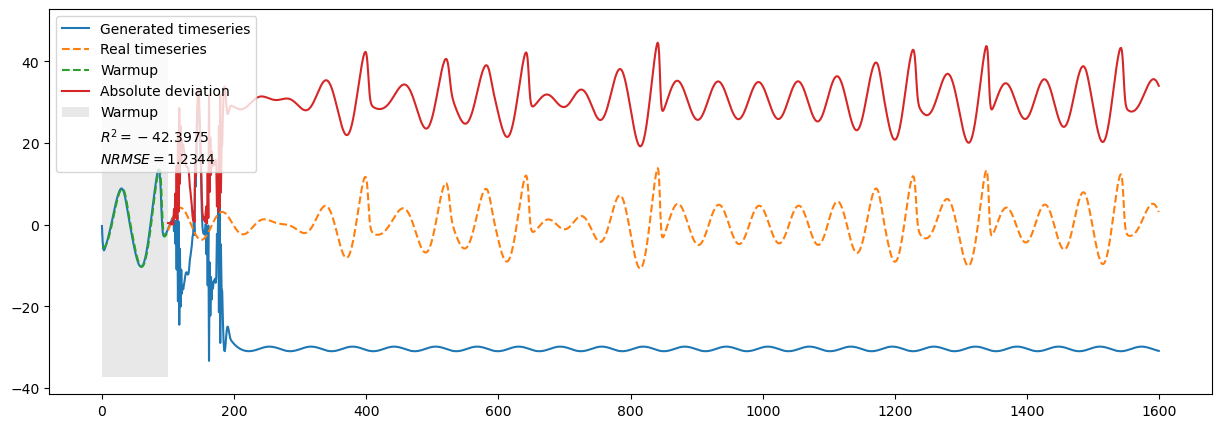

In [148]:
plot_generation(X_gen[:, :1], X_t[:, :1], nb_generations, warming_out=warming_out[:, :1],
                warming_inputs=warming_inputs[:, :1], seed_timesteps=seed_timesteps)


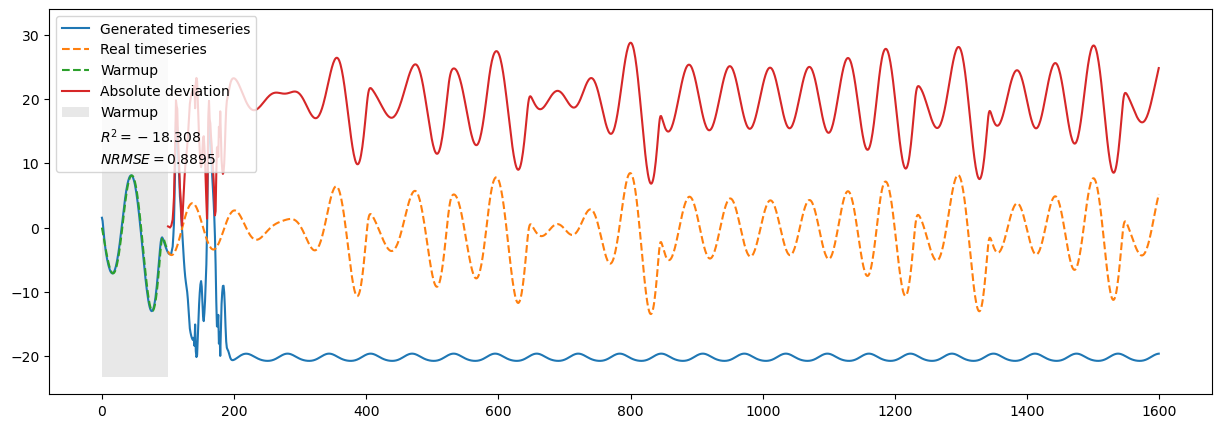

In [149]:
plot_generation(X_gen[:, 1:2], X_t[:, 1:2], nb_generations, warming_out=warming_out[:, 1:2],
                warming_inputs=warming_inputs[:, 1:2], seed_timesteps=seed_timesteps)
